
## Impact of Various Kernels for Support Vector Machines

#### Kristen Stewart
#### Walker Department of Mechanical Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The University of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Misael Morales, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/misaelmmorales/)


### Executive Summary

Support Vector Machines are a common machine learning algorithm that utilizes a kernel trick to increase dimensionality to classify data without actually changing the dimensionality of the dataset, so this workflow was created to demonstrate the impact of various kernels on the same dataset. This workflow creates a synthetic dataset with randomly categorized response variables and then many different kernels are implemented and tuned to illustrate how different kernels impact the response predictions. I learned that with the capability of implementing custom kernels, the relationships between data can be highly nonlinear, but different datasets may benefit from different types of kernels. It is recommended for datasets without explicit linear relationships to test multiple types of kernels and tune them in order to determine the proper kernel function before finalizing the model.


### Import Packages


In [2]:
import numpy as np                                          # for working with data and model arrays
import matplotlib.pyplot as plt                             # for plotting and visualizing data and models
import pandas as pd                                         # for organizing data
#import os                                                   # need to organize, set current directory
import seaborn as sns                                       # for data visualization of synthetic dataset
from sklearn.svm import SVC                                 # used for support vector machine classifier methods
from sklearn.model_selection import train_test_split        # split into training and testing datasets
#from sklearn.metrics import confusion_matrix                # for sumarizing model performance
from sklearn.preprocessing import StandardScaler            #used for scaling data to train a model 
from sklearn.model_selection import StratifiedShuffleSplit  # used for tuning hyperparameters
from sklearn.model_selection import GridSearchCV            # used for tuning hyperparameters
scaler = StandardScaler()                                   # instantiate a standard scaler for use later

### Functions

The following functions will be used in the workflow. They were adapted from Professor Michael Pyrcz (@GeostatsGuy) in SubsurfaceDataAnalytics_SupportVectorMachines.ipynb

In [3]:
def visualize_model(model,nxfeature,nyfeature,xfeature,yfeature,response):# plots the data points and the decision tree prediction 
    n_classes = 10

    x_min, x_max = min(nxfeature)-1, max(nxfeature)+1 
    y_min, y_max = min(nyfeature)-1 , max(nyfeature)+1
    #y_min,y_max = 'low','high'
    plot_step = 100
    resp_min = round(min(response)); resp_max = round(max(response));
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, plot_step),
                     np.linspace(y_min, y_max, plot_step))
    
    z_min = round(min(response)); z_max = round(max(response))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    trans = scaler.inverse_transform(np.c_[xx.ravel(), yy.ravel()])
    trans_x = trans[:,0].reshape(xx.shape)
    trans_y = trans[:,1].reshape(xx.shape)
    
    cs = plt.contourf(trans_x, trans_y, Z, vmin=z_min, vmax=z_max)

    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None,  norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, edgecolors="black")
    plt.xlabel(xfeature.name)
    plt.ylabel(yfeature.name)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(response.name, rotation=270, labelpad=20)
    return(plt)

def plot_svc_decision_function(model,plt, plot_support=True): # modified from Jake VanderPlas's Python Data Science Handbook  
    """Plot the decision function for a 2D SVC"""
    xlim = [-2.5,15]
    ylim = [-2.5,7]
    # plot support vectors
    sv = scaler.inverse_transform(model.support_vectors_)
    if plot_support:
        plt.scatter(sv[:, 0],
                   sv[:, 1],
                   s=3, linewidth=8,alpha = 0.6, facecolors='black');

#### Kernel Functions
The following function is used to create a custom kernel.

In [4]:
def create_exp_kernel(xfeature,yfeature):  # create kernel that relates features by an exponential
    return np.dot(np.power(xfeature,2),np.power(yfeature.T,2))

### Generate Data

The following workflow will use a synthetic random dataset sampled from a multi-Gaussian distribution, where the parameters of the covariance matrix and mean are predefined. The classification of each datapoint is binned to label either 1, 2, or 3. For generalizability, the predictor features are 

    * Feature1
    * Feature2 

where the covariance between the two is -0.25. 

The response feature is

    * Response
which has a set covariance between the features, but has been categorized into 

    * ResponseCat2
which has 3 categories defined by ranges of bins.

In [5]:
np.random.seed(seed=13)
num_samples = 200

# The desired mean values of the sample.
des_mean = np.array([5.0, 2.50, 10.0])

# The desired covariance matrix.
covar = np.array([[  3.40, -0.25, -1.05],
                 [ -0.25,  0.90,  0.70],
                 [ -1.05,  0.70,  1.25]])

# Generate the random samples.
rng = np.random.default_rng(seed=12345)
y = rng.multivariate_normal(des_mean, covar, size=num_samples)

# Create Pandas dataframe
df = pd.DataFrame(y, columns = ['Feature1','Feature2','Response'])

# Categorize values
bins = [0,9,11,20]                # assign the bins
labels = [1,2,3]                  # assign the labels to include in the dataframe

category = pd.cut(df['Response'],bins,labels=labels)     # create array with the labels for response feature
df['ResponseCat2'] = category                   # add the categorized feature to DataFrame   
df.head(n=10)                    # check to see categorical labels are saved

,Feature1,Feature2,Response,ResponseCat2
0,6.873326,1.322896,7.671269,1
1,5.428764,2.746244,9.580844,2
2,7.171108,1.388674,8.592687,1
3,7.483977,-0.403439,7.154238,1
4,5.893305,1.688313,8.596467,1
5,4.627716,2.300865,8.943447,1
6,3.447741,1.073855,9.947782,2
7,4.967447,2.262766,8.542602,1
8,4.950541,2.575226,9.073834,2
9,4.588209,0.117653,9.666496,2


### Standardize data
Support Vector Machines rely on distance measurements, so standardization is essential to ensure there is no distortion between different feature measurements.

In [6]:
normX = scaler.fit_transform(df.loc[:,['Feature1','Feature2']])  ### normalize all the data
# save normalized features into dataframe
df['nFeature1'] = normX[:,0]
df['nFeature2'] = normX[:,1]
normPredX = df.loc[:,['nFeature1','nFeature2']]

### Visualize randomly generated data
We want to ensure the data is distributed evenly since it is randomly created.

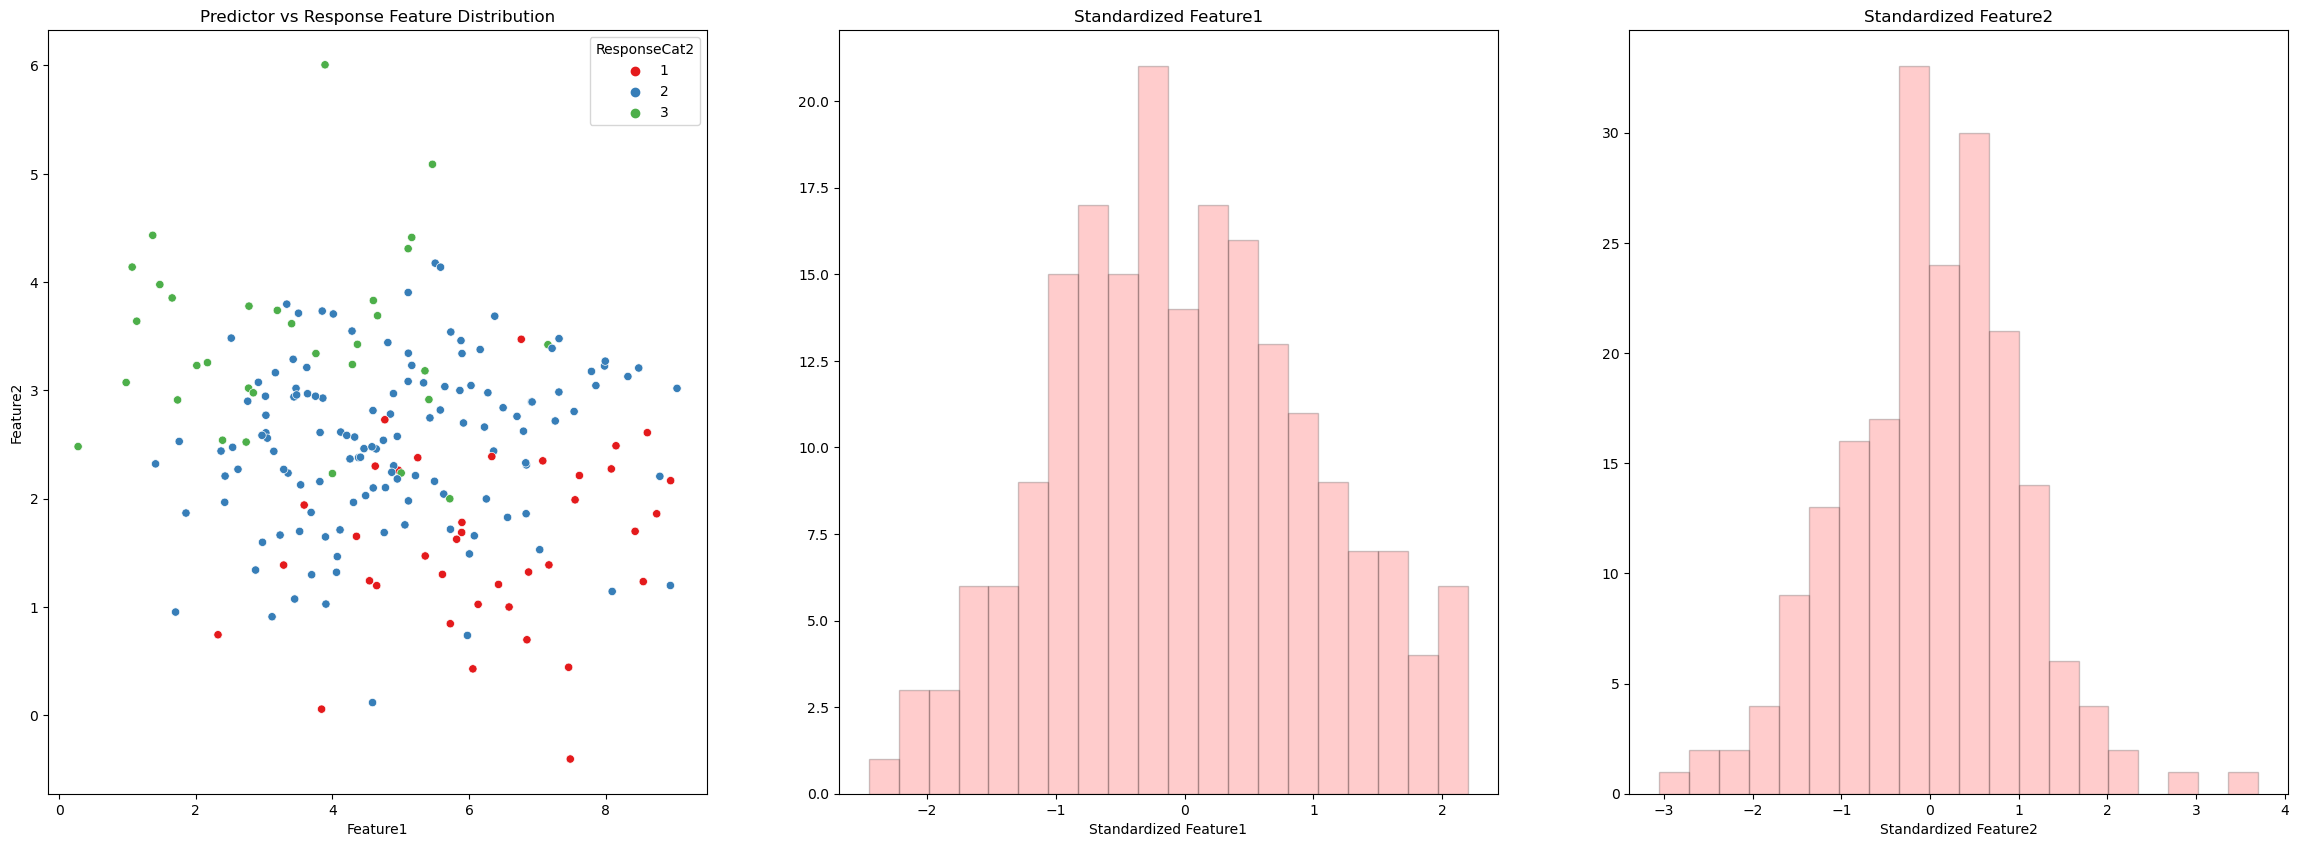

In [7]:
plt.subplot(231)
sns.scatterplot(x = 'Feature1', y = 'Feature2', hue='ResponseCat2',data=df,legend='full',palette = "Set1")
plt.title('Predictor vs Response Feature Distribution')

plt.subplot(232)
plt.hist(df["nFeature1"], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.xlabel('Standardized Feature1'); plt.title('Standardized Feature1')

plt.subplot(233)
plt.hist(df["nFeature2"],alpha=0.2,color='red',edgecolor = 'black', bins=20)
plt.xlabel('Standardized Feature2'); plt.title('Standardized Feature2')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.5, top=3.5, wspace=0.2, hspace=0.2)

### Impact of Various Kernels on Support Vector Machines

It is important to choose the right type of kernel given your data so the model can be as accurate as possible. This workflow will use one dataset and demonstrate how different support vector machines (SVM) can predict the response features given various tuned kernels.

#### Background on Support Vector Machines
Support Vector Machines can be used for classification or regression, but will focus on classification here. It is a supervised learning process to predict the response feature given predictor features. To achieve this, it creates a hyperplane which strives to maximize the width of the margin (i.e., the separation between the categories) and minimize the error between the support vectors. A benefit of SVM is that it utilizes the kernel trick, which allows you to map to a higher dimensional space without performing the operation and can use a matrix of covariances between features.

#### Scikit-learn Support Vector Classifier
Typically, SVM is considered a binary classifier. However, it has been adapted for multi-class separation using a one-to-rest approach. This creates a binary classification per class by comparing each class to the group of the rest of the classes. This was selected in this workflow to simplify the classification by reducing the number of classifications needed compared to a one-to-one approach.

1. I will begin with creating standard, pre-defined kernels from scikit-learn, such as: 
* Linear kernel
* Polynomial kernel 
    a. 3rd, 4th, and 5th degree polynomials
* Radial Basis Function kernel
* Sigmoid kernel

2. I will define a custom kernel and implement into a SVM


3. I will plot all of the trained and tuned SVM models to compare side-by-side 


### 1. Split into Training and Testing data. 
We want to ensure some data is withheld for validation purposes. 25% of data is withheld here and separated into predictor and response features.

In [8]:
train, test = train_test_split(df,random_state=13, test_size=0.25)
train_X = train.loc[:,['Feature1','Feature2']]
train_X = train_X.reset_index(drop = True)

train_y = train['ResponseCat2']
train_y = train_y.reset_index(drop = True)

### 2. Scale Training Data
Like the entire dataset, the data needs to be standardized in order to measure distances.

In [9]:
scaler = StandardScaler()
normX_t = scaler.fit_transform(train_X)
train_X['nFeature1'] = normX_t[:,0]
train_X['nFeature2'] = normX_t[:,1]
normTrainX = train_X.loc[:,['nFeature1','nFeature2']]
train_X.head()

,Feature1,Feature2,nFeature1,nFeature2
0,3.288040,2.270596,-0.803827,-0.229269
1,3.688899,1.873482,-0.591345,-0.640159
2,4.293171,3.239196,-0.271041,0.772932
3,4.746922,2.539256,-0.030523,0.048711
4,5.898449,3.340544,0.579862,0.877796


### 3. Create and Tune Linear Kernel

This section develops a SVM with a linear kernel, where 
\begin{equation}
k(x_m,x_n) = (x_m^Tx_n),
\end{equation}

This is a predefined kernel type in scikit-learn and the hyperparamter is C, the weight of the sum of errors.

To tune C: 
* Define an array of different C weights
* Use a cross-validation approach to train and test models using the various C weights
* Measure the mean test score for each model and select the model that provides the best fit (i.e., the highest mean test score)

The cross-validation approach is adapted from Professor Michael Pyrcz (@GeostatsGuy) in the SubsurfaceDataAnalytics_SupportVectorMachines.ipynb workflow

In [10]:
C_range = np.array([0.01, 0.1, 1, 10]) # initialize range of C's to test
kernelType = ['linear']                     # for tuning purposes, initialize type of kernel

param_grid = dict(C=C_range,kernel=kernelType)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=99)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(normPredX, df['ResponseCat2'])
scores = grid.cv_results_['mean_test_score'].reshape(len(C_range))

totalMax = 0
for index,i in enumerate(scores):
   if i == max(scores):
    bestC_linear = C_range[index]
maxScore_linear = max(scores)
print('Optimal C value: ',bestC_linear)

Optimal C value:  1.0


Now that we have a tuned hyperparameter, we can develop our prediction model.

#### Train SVM model with optimal linear kernel parameters

Using the optimal C value selected from cross-validation, train the SVM model using the linear kernel.
```python
svm_linear = SVC()
```
In this scenario, the optimal C = 1.0

In [11]:
svm_linear = SVC(kernel ='linear', C = bestC_linear )   # Create a SVC classifier using a linear kernel
svm_linear.fit(normTrainX, train_y)    # Train the classifier

SVC(kernel='linear')

We now have our linear kernel model saved, and will now create our next kernel function.

### 4. Create and Tune Polynomial Kernel

This section develops a SVM with a polynomial kernel, where 
\begin{equation}
k(x_m,x_n) = (x_m^Tx_n)^d,
\end{equation}

This is a predefined kernel type in scikit-learn and the hyperparamters are C, the weight of the sum of errors and d, the degree of the polynomial.

To tune C: 
* Define an array of different C weights
* Define an array of different degrees
* Use a cross-validation approach to train and test models using the various C weights
* Measure the mean test score for each model and select the model that provides the best fit (i.e., the highest mean test score) for each degree polynomial

In [12]:
C_range = np.array([0.01, 0.1, 1, 10,1e2])
degree_range = np.array([3,4,5])
kernelType = ['poly']

param_grid = dict(degree=degree_range, C=C_range, kernel=kernelType)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=99)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(normPredX, df['ResponseCat2'])
scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),len(degree_range))

totalMax = [0, 0, 0]
bestC_poly = [0,0,0]
for index,i in enumerate(scores):
    for indexD, currScore in enumerate(i):
        if totalMax[indexD]<currScore:
            totalMax[indexD] = currScore
            bestC_poly[indexD] = index
bestC_poly = [C_range[i] for i in bestC_poly] 
maxScore_poly = totalMax
print('3rd Order C:{0}, 4th Order C:{1}, 5th Order C:{2}'.format(bestC_poly[0],bestC_poly[1], bestC_poly[2]))

3rd Order C:10.0, 4th Order C:1.0, 5th Order C:100.0


Now that we have a tuned hyperparameter, we can develop our prediction model. It is worth noting that different polynomials have different optimal C weighting terms. Each term will be used for their corresponding new model that needs to be trained next.

#### Train SVM model with optimal polynomial kernel parameters

Using the optimal C value selected from cross-validation, instantiate and fit each SVM model using the polynomial kernel of degrees 3, 4, and 5.

```python
svm_poly = SVC()
```
In this scenario, 
* 3rd order C = 10
* 4th order C = 1
* 5th order C = 100

In [13]:
# 3rd order
svm_poly3 = SVC(kernel ='poly', degree = 3, C = bestC_poly[0])
svm_poly3.fit(normTrainX,train_y) 

# 4th order
svm_poly4 = SVC(kernel ='poly', degree = 4, C = bestC_poly[0])
svm_poly4.fit(normTrainX,train_y) 

# 5th order
svm_poly5 = SVC(kernel ='poly', degree = 5, C = bestC_poly[2])
svm_poly5.fit(normTrainX,train_y) 

SVC(C=100.0, degree=5, kernel='poly')

We will save the models for the 3rd, 4th, and 5th order polynomials to visualize later. 

### 5. Create and Tune Radial Basis Function Kernel

This section develops a SVM with a polynomial kernel, where 
\begin{equation}
k(x_m,x_n) = e^{-\gamma||x_m-x_n||^2}
\end{equation}

This is a predefined kernel type in scikit-learn and the hyperparamters are C, the weight of the sum of errors and gamma, which affects the influence of each training point on others.

To tune C and gamma: 
* Define an array of different C weights
* Define an array of different gamma weights
* Use a cross-validation approach to train and test models using all combinations of parameters
* Measure the mean test score for each model and select the model that provides the best fit (i.e., the highest mean test score)

In [14]:
C_range = np.array([0.01,0.1,1,10])
gamma_range = np.array([1e-2, 1e-1,1,10,100])

param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=99)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(normPredX, df['ResponseCat2'])
scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),len(gamma_range))

totalMax = 0
for index,i in enumerate(scores):
    rowMax = max(i)
    if totalMax <= rowMax:
        totalMax = rowMax
        bestC_rbf = index
        for indexG,rowVal in enumerate(i):
            if rowVal == max(i):
                bestGamma_rbf = indexG
maxScore_rbf = totalMax
bestC_rbf = C_range[bestC_rbf]  
bestGamma_rbf = gamma_range[bestGamma_rbf]
print('Optimal C: {0}, Optimal Gamma: {1}'.format(bestC_rbf,bestGamma_rbf))

Optimal C: 10.0, Optimal Gamma: 1.0


Now that we have tuned hyperparameters, we can develop our prediction model.

#### Train SVM model with optimal RBF kernel parameters

Using the optimal C value selected from cross-validation, instantiate and fit the SVM model using the RBF kernel 

```python
svm_rbf = SVC()
```
In this scenario, 
* C = 10
* gamma = 1


In [15]:
svm_rbf = SVC(kernel ='rbf',C=bestC_rbf, gamma=bestGamma_rbf,random_state=13)
svm_rbf.fit(normTrainX, train_y)

SVC(C=10.0, gamma=1.0, random_state=13)

### 6. Create and Tune Sigmoid Kernel

This section develops a SVM with a linear kernel, where 
\begin{equation}
k(x_m,x_n) = tanh(x_m^Tx_n),
\end{equation}

This is a predefined kernel type in scikit-learn and the hyperparameter is C, the weight of the sum of errors.

To tune C: 
* Define an array of different C weights
* Use a cross-validation approach to train and test models using the various C weights
* Measure the mean test score for each model and select the model that provides the best fit (i.e., the highest mean test score)


In [16]:
C_range = np.array([1, 10, 1e2, 1e4])
kernelType = ['sigmoid']
param_grid = dict(C=C_range,kernel=kernelType)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=99)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(normPredX, df['ResponseCat2'])
scores = grid.cv_results_['mean_test_score'].reshape(len(C_range))
totalMax = 0

for index,i in enumerate(scores):
   if i == max(scores):
    bestC_sig = C_range[index]
maxScore_sig = max(scores)
print('Optimal C value: ',bestC_sig)

Optimal C value:  1.0


Now that we have tuned the hyperparameter, we can develop our prediction model.
​
#### Train SVM model with optimal sigmoid kernel parameters
​
Using the optimal C value selected from cross-validation, instantiate and fit the SVM model using the sigmoid kernel 
​
```python
svm_sig = SVC()
```
In this scenario, C = 1.0

In [17]:
svm_sig = SVC(kernel='sigmoid',C=bestC_sig)
svm_sig.fit(normTrainX, train_y)

SVC(kernel='sigmoid')

### 7. Create new custom kernel
This section demonstrates how a SVM can be developed with a custom kernel, where you can create a function to describe the kernel (see Functions section above)

For this demonstration, a kernel function was arbitrarily chosen as
\begin{equation}
k(x_m,x_n) = ((x_m^T)^2(x_n)^2,
\end{equation}

The hyperparameter is still C, the weight of the sum of errors.

The rest of the process to develop the SVM is similar to previous examples.

To tune C: 
* Define an array of different C weights
* Use a cross-validation approach to train and test models using the various C weights
* Measure the mean test score for each model and select the model that provides the best fit (i.e., the highest mean test score)

In [18]:
C_range = [1,10,1e3]
kernelType = [create_exp_kernel]
param_grid = dict(C=C_range,kernel=kernelType)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=99)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(normPredX, df['ResponseCat2'])
scores = grid.cv_results_['mean_test_score'].reshape(len(C_range))

totalMax = 0
for index,i in enumerate(scores):
   if i == max(scores):
    bestC_cust = C_range[index]
maxScore_cust = max(scores)
print('Optimal C value: ',bestC_cust)

Optimal C value:  1000.0


Now that we have tuned the hyperparameter, we can develop our prediction model.
​
#### Train SVM model with optimal custom kernel parameters
​
Using the optimal C value selected from cross-validation, instantiate and fit the SVM model using the custom kernel 
​
```python
customSVM = SVC(kernel=create_exp_kernel)
```
In this scenario, C = 1000

In [19]:
#bestC_cust = 1e3
customSVM = SVC(kernel=create_exp_kernel,C=bestC_cust)
customSVM.fit(normTrainX, train_y)

SVC(C=1000.0, kernel=<function create_exp_kernel at 0x7f9f94720700>)

### Results
#### Visualize all SVM Models
Now that all models are created and tuned, we can plot them all to see how various kernels affect the predictions.

/Users/kristenstewart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/kristenstewart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/kristenstewart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/kristenstewart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/kristenstewart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/kristenstewart/opt/anaconda3/lib/python3.9/

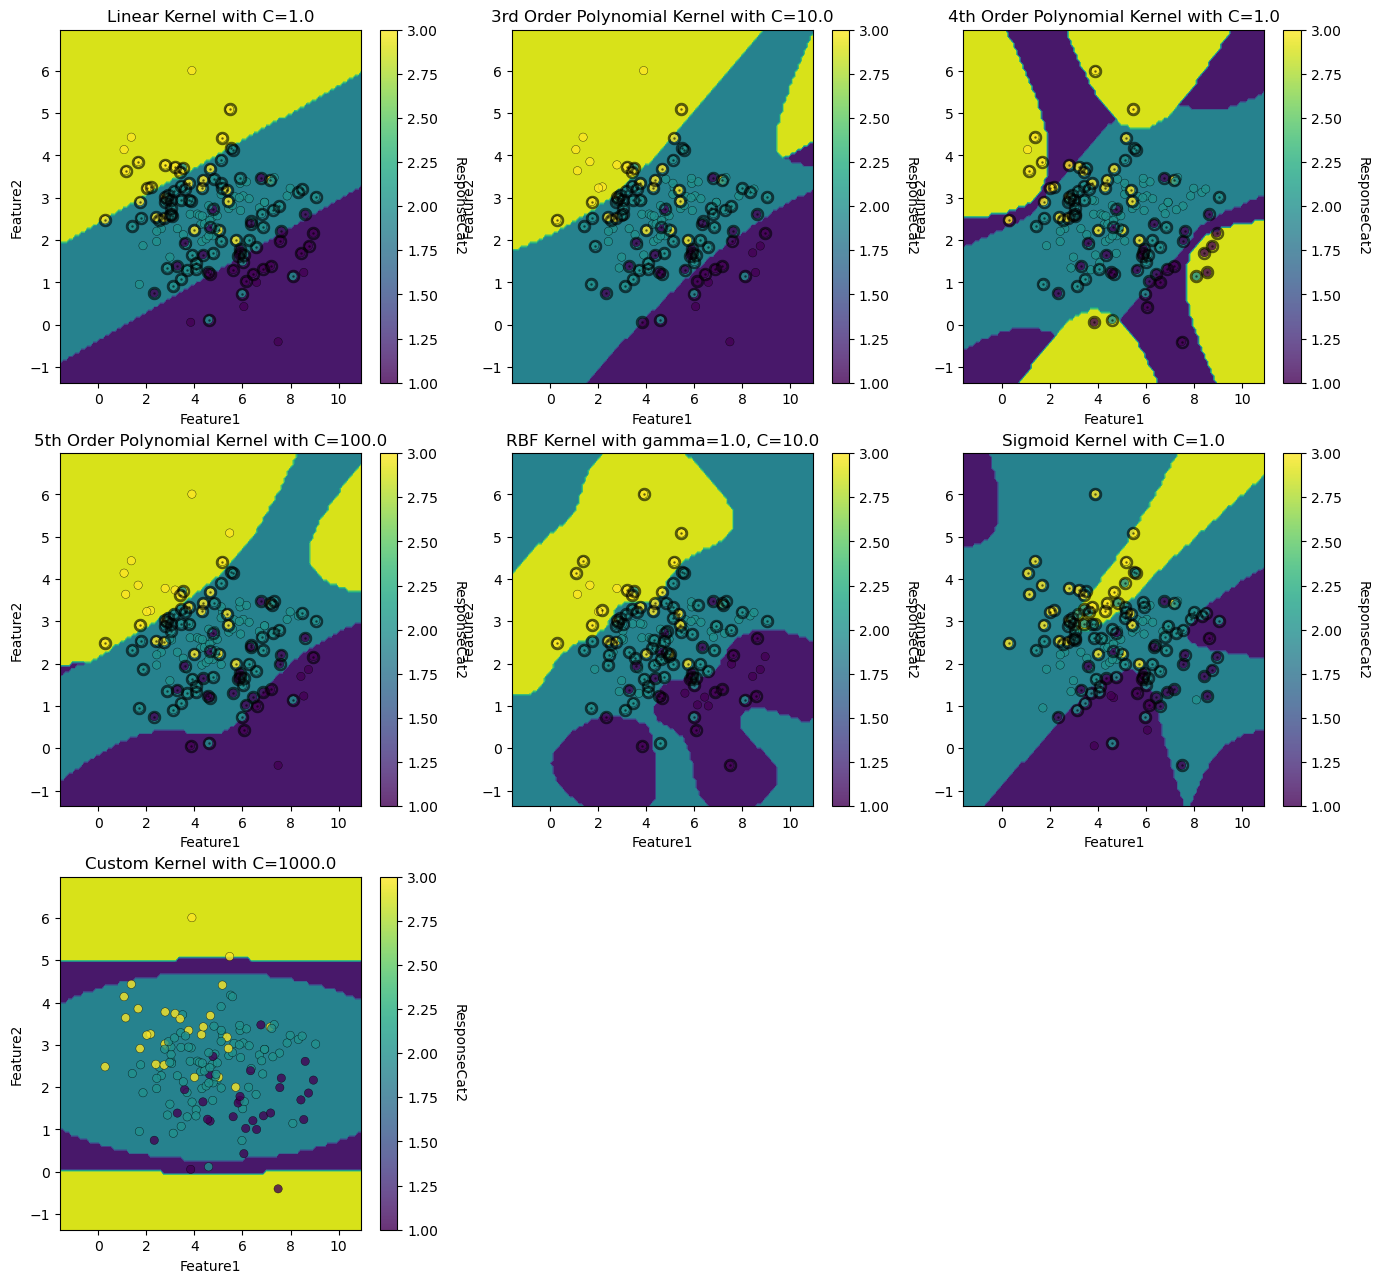

In [20]:
# Linear
plt.subplot(331)
plt = visualize_model(svm_linear,train_X["nFeature1"],train_X["nFeature2"],train_X["Feature1"],train_X["Feature2"],train_y)
plot_svc_decision_function(svm_linear,plt,plot_support=True)
plt.title("Linear Kernel with C={}".format(bestC_linear))

# Cubic Polynomial
plt.subplot(332)
plt = visualize_model(svm_poly3,train_X["nFeature1"],train_X["nFeature2"],train_X["Feature1"],train_X["Feature2"],train_y)
plot_svc_decision_function(svm_poly3,plt,plot_support=True)
plt.title("3rd Order Polynomial Kernel with C={}".format(bestC_poly[0]))

# 4th Order Polynomial
plt.subplot(333)
plt = visualize_model(svm_poly4,train_X["nFeature1"],train_X["nFeature2"],train_X["Feature1"],train_X["Feature2"],train_y)
plot_svc_decision_function(svm_poly4,plt,plot_support=True)
plt.title("4th Order Polynomial Kernel with C={}".format(bestC_poly[1]))

# 5th Order Polynomial
plt.subplot(334)
plt = visualize_model(svm_poly5,train_X["nFeature1"],train_X["nFeature2"],train_X["Feature1"],train_X["Feature2"],train_y)
plot_svc_decision_function(svm_poly5,plt,plot_support=True)
plt.title("5th Order Polynomial Kernel with C={}".format(bestC_poly[2]))

# RBF 
plt.subplot(335)
plt = visualize_model(svm_rbf,train_X["nFeature1"],train_X["nFeature2"],train_X["Feature1"],train_X["Feature2"],train_y)
plot_svc_decision_function(svm_rbf,plt,plot_support=True)
plt.title("RBF Kernel with gamma={0}, C={1}".format(bestGamma_rbf,bestC_rbf))

# Sigmoid
plt.subplot(336)
plt = visualize_model(svm_sig,train_X["nFeature1"],train_X["nFeature2"],train_X["Feature1"],train_X["Feature2"],train_y)
plot_svc_decision_function(svm_sig,plt,plot_support=True)
plt.title("Sigmoid Kernel with C={}".format(bestC_sig))

# Custom 
plt.subplot(337)
plt = visualize_model(customSVM,train_X["nFeature1"],train_X["nFeature2"],train_X["Feature1"],train_X["Feature2"],train_y)
plt.title("Custom Kernel with C={}".format(bestC_cust))

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)

#### Determine best fit for this dataset based on cross validation scores

In [21]:
allFit = [maxScore_linear, *maxScore_poly, maxScore_rbf,maxScore_sig, maxScore_cust]
kernelTypes = ['Linear','3rd','4th','5th','RBF','Sig', 'Custom']
bestFit = max(allFit)
index = allFit.index(bestFit)
bestModel = kernelTypes[index]
print('Best Model Type: {0} with CV Score: {1}'.format(bestModel,bestFit))

Best Model Type: 5th with CV Score: 0.748


Now, we want to visualize the cross validation scores to select the best model type.

Text(0, 0.5, 'CV scores')

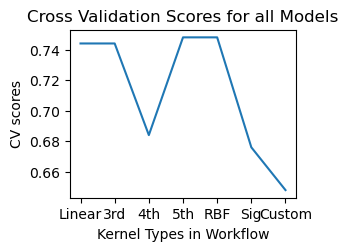

In [22]:
plt.subplot(221)
plt.plot(kernelTypes,allFit)
plt.title('Cross Validation Scores for all Models')
plt.xlabel('Kernel Types in Workflow'); plt.ylabel('CV scores')

As the subplots with all of the SVM models with different kernels illustrate, different kernels have the capability to produce very different predictions in the same feature space. As the dataset was not very complex, there are some models (e.g., 4th order polynomial, RBF, and sigmoid kernels) which demonstrate overfit. Overall, the most accurate model would be the 5th order polynomial, with a C = 100. The RBF kernel with a C = 10 and gamma = 1 has a very close cross-validation score, but by inspecting the model, demonstrates more overfit than the 5th order polynomial.

It would always be beneficial to test multiple kernels for a given dataset to ensure your SVM is most accurately classifying data.

## Parting Comments

Thank you for following along with my workflow.

I am a PhD student in Mechanical Engineering studying the biomechanics of human movement. I am very interested in integrating machine learning techniques to better understand and predict activities of daily living. Please feel free to reach out. My email is kristen.stewart@utexas.edu

## I hope this was helpful,

*Kristen Stewart*

Graduate Research Assistant | Neuromuscular Biomechanics Lab | Walker Department of Mechanical Engineering | 
The University of Texas at Austin


___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
